<a href="https://colab.research.google.com/github/Zafar-Lab/scDREAMER/blob/main/2109_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # difference between gpu '0' and '1'

"""
# for reproducibility with server...

os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" # setting "true"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
"""

import numpy as np
import tensorflow as tf2
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import scipy.io
from sklearn.decomposition import PCA
import pdb

import pandas as pd
import scanpy as sc


import scipy.sparse
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import stats 
from scipy import * 
import datetime 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

os.getpid()


2023-09-27 11:21:54.600114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 11:21:55.223192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


154709

In [2]:

np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)
tf2.random.set_seed(0)
tf2.keras.utils.set_random_seed(0)


In [3]:
import warnings
warnings.filterwarnings('ignore')
"""
!pip install -U scipy==1.5.0
!pip install scanpy==1.8.2
!pip install -U scikit-learn
"""

'\n!pip install -U scipy==1.5.0\n!pip install scanpy==1.8.2\n!pip install -U scikit-learn\n'

Building model

In [4]:

name = "Immune_Human"
name = "Pancreas"
name = "Human_Retina"
name = "Lung"
name = "Healthy_Heart"
name = "Lung"
name = "Human_Mouse"


In [5]:


data_path = {
"Immune_Human" : "/home/ajita/Documents/data_integration/Immune/Immune_ALL_human.h5ad",
"Pancreas" : "/home/ajita/Documents/data_integration/Pancreas/Pancreas.h5ad",
"Human_Mouse" : "/home/ajita/Documents/data_integration/hum_mou/hcl_mca_merged.h5ad",
"Human_Retina" : "/home/ajita/Documents/data_integration/Human_Retina/Human_Retina.h5ad",
"Lung" : "/home/ajita/Documents/data_integration/Lung/Lung_atlas_public.h5ad",
"Healthy_Heart" : "/home/ajita/Documents/data_integration/Healthy_Heart/Healthy_human_heart_adata.h5ad" 
}


batch_key_dict = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 "Healthy_Heart" : "sampleID"
                 
                }
cell_type_key_dict = {'Immune_Human' : 'final_annotation',
                 'Lung' : 'cell_type',  
                 'Pancreas' : 'celltype', 
                 'Human_Mouse' : "celltype", 
                 "Human_Retina":"Subcluster",
                "Healthy_Heart" : "celltype"
                    }    

shuffle_type_dict = {'Immune_Human' : 1, 'Lung' : 2, 'Pancreas' : 1, 'Human_Mouse' : 1, 
                 "Human_Retina":2,"Healthy_Heart" : 1
                    }
learning_rate = {
                 'Immune_Human' : {"lr_ae" : 0.0002, "lr_dis": 0.0007, "lr_bc": 0.0007},
                 'Lung' : {"lr_ae" : 0.0002 , "lr_dis": 0.0007, "lr_bc": 0.0007},
                 'Pancreas' : {"lr_ae" : 0.0002, "lr_dis": 0.0007, "lr_bc": 0.0007},
                 'Human_Retina': {"lr_ae" : 0.0002, "lr_dis": 0.0007, "lr_bc": 0.0007},
                 'Human_Mouse' : {"lr_ae" : 0.0001, "lr_dis": 0.00001, "lr_bc": 0.0007},
                 "Healthy_Heart" : {"lr_ae" : 0.0001, "lr_dis": 0.00001, "lr_bc": 0.0007}
}


# big datasets: 20 dimensions
latent_dim = {
                'Immune_Human' : 10,
                 'Lung' : 10,
                 'Pancreas' : 10,
                 'Human_Mouse' : 20,
                 'Human_Retina': 10,
                 "Healthy_Heart" : 20
    
            }
BS = {
    'Immune_Human' : 128,
     'Lung' : 128,
     'Pancreas' : 128,
     'Human_Mouse' : 128,
     'Human_Retina': 128,
     "Healthy_Heart" : 128
}

epoch_dict = {
    'Immune_Human' : 150,
     'Lung' : 250,
     'Pancreas' : 300,
     'Human_Mouse' : 200,
     'Human_Retina': 300,
     "Healthy_Heart" : 300
}

"""
Below variable takes care of sparse matrix
If 1: pd.DataFrame.sparse.from_spmatrix(Ann.X) is used
If 0: pd.DataFrame(Ann.X)

By default 0, unless scarcity not handled by basis pandas operation
"""

sparseIP= {
        "Healthy_Heart" : 1,
    'Immune_Human' : 0, 
     'Lung' : 1,
     'Pancreas' : 0,
     'Human_Mouse' : 1,
     "Human_Retina": 0
}


2023-09-27 11:21:57.947786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:af:00.0, compute capability: 7.5


came in load_gene
updated hvg
here [61 61 61 ... 20 90 40]
Data set to work on:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(933704, 2000)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(933704, 2)
encoder input shape  Tensor("concat:0", shape=(?, 2002), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_1:0", shape=(?, 22), dtype=float32)
KL gaussian z Tensor("mul_10:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_9:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cluster DRA on DataSet /home/ajita/Documents/data_integrat

2023-09-27 11:22:28.346711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Epoch : [0] ,  a_loss = 83.4038, d_loss: -0.0019 ,  db_loss: 0.3968
Epoch : [1] ,  a_loss = 84.3661, d_loss: -0.0004 ,  db_loss: 0.4213
Epoch : [2] ,  a_loss = 83.4272, d_loss: -0.0001 ,  db_loss: 0.4033
Epoch : [3] ,  a_loss = 79.4402, d_loss: -0.0001 ,  db_loss: 0.4546
Epoch : [4] ,  a_loss = 78.6572, d_loss: -0.0001 ,  db_loss: 0.4306
Epoch : [5] ,  a_loss = 84.5629, d_loss: -0.0001 ,  db_loss: 0.5061
Epoch : [6] ,  a_loss = 85.2699, d_loss: -0.0000 ,  db_loss: 0.3769
Epoch : [7] ,  a_loss = 81.2563, d_loss: -0.0000 ,  db_loss: 0.5291
Epoch : [8] ,  a_loss = 83.3524, d_loss: -0.0000 ,  db_loss: 0.4645
Epoch : [9] ,  a_loss = 81.8115, d_loss: -0.0000 ,  db_loss: 0.5478
Epoch : [10] ,  a_loss = 79.7160, d_loss: -0.0000 ,  db_loss: 0.5336
Epoch : [11] ,  a_loss = 80.2239, d_loss: -0.0000 ,  db_loss: 0.5117
Epoch : [12] ,  a_loss = 78.1707, d_loss: -0.0000 ,  db_loss: 0.4838
Epoch : [13] ,  a_loss = 77.9561, d_loss: -0.0000 ,  db_loss: 0.5007
Epoch : [14] ,  a_loss = 76.1667, d_loss: -0

Epoch : [119] ,  a_loss = 73.1790, d_loss: -0.0000 ,  db_loss: 0.4183
Epoch : [120] ,  a_loss = 77.9786, d_loss: -0.0000 ,  db_loss: 0.4050
Epoch : [121] ,  a_loss = 79.8782, d_loss: -0.0000 ,  db_loss: 0.4639
Epoch : [122] ,  a_loss = 79.6152, d_loss: -0.0000 ,  db_loss: 0.5203
Epoch : [123] ,  a_loss = 80.6753, d_loss: -0.0000 ,  db_loss: 0.4632
Epoch : [124] ,  a_loss = 81.2603, d_loss: -0.0000 ,  db_loss: 0.4744
Epoch : [125] ,  a_loss = 79.3653, d_loss: -0.0000 ,  db_loss: 0.4003
Epoch : [126] ,  a_loss = 82.5181, d_loss: -0.0000 ,  db_loss: 0.5406
Epoch : [127] ,  a_loss = 75.4916, d_loss: -0.0000 ,  db_loss: 0.5204
Epoch : [128] ,  a_loss = 76.1162, d_loss: -0.0000 ,  db_loss: 0.5052
Epoch : [129] ,  a_loss = 77.0909, d_loss: -0.0000 ,  db_loss: 0.4668
Epoch : [130] ,  a_loss = 80.2695, d_loss: -0.0000 ,  db_loss: 0.4578
Epoch : [131] ,  a_loss = 78.0477, d_loss: -0.0000 ,  db_loss: 0.4694
Epoch : [132] ,  a_loss = 80.7074, d_loss: -0.0000 ,  db_loss: 0.3731
Epoch : [133] ,  a_l

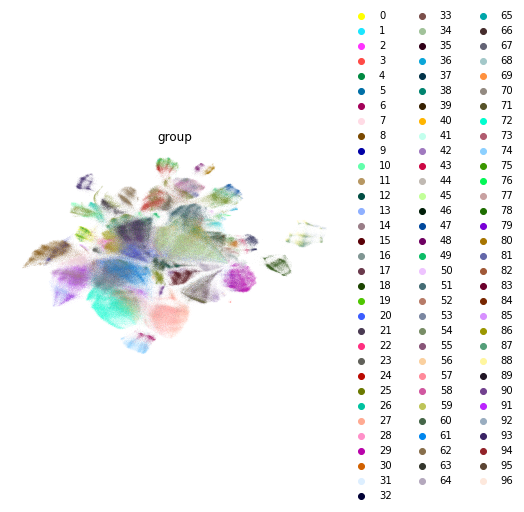

None


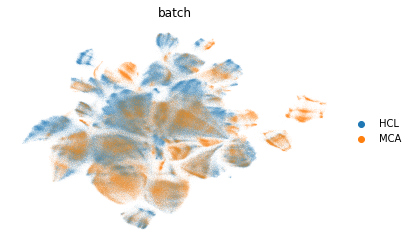

None
Computing NMI ...
Done !
NMI = 0.5796844080773516


In [6]:
    
# add avg of losses,

import src.model_big_dataset as model


run_config = tf.ConfigProto()

run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

with tf.Session(config = run_config) as sess:

    dreamer = model.scDREAMER(
        sess,
        epoch = epoch_dict[name],
        dataset_name = data_path[name],
        batch = batch_key_dict[name],
        cell_type = cell_type_key_dict[name],
        name = name,
        lr_ae = learning_rate[name]['lr_ae'],
        lr_dis = learning_rate[name]['lr_dis'],
        lr_bc = learning_rate[name]['lr_bc'],
        batch_size = BS[name],
        z_dim = latent_dim[name],
        shuffle_type = shuffle_type_dict[name],
        sparseIP = sparseIP[name]
        )

    dreamer.train_cluster()

